## Objectives

In [1]:
# -- Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from sys.path import insert
from os.path import join
from scipy import stats
from scipy.signal import correlate

sys.path.insert(0,'/home/santi_noacco/Desktop/SoftwareSetup/Python/')
import NoaccoLibrary as nlib

Welcome to JupyROOT 6.20/04


In [2]:
sns.set(style='ticks',color_codes=True)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.0})
# sns.set_style('ticks')

# Font BIGGER SIZE!

## Parameters


_CMN Units_ :: $10^8$ $kg^{-1}$

_CD34 Units_ :: $10^6$ $kg^{-1}$

_nomErr Vol_ :: $1$ $ml$

_nomErr interTime_ :: $1$ $day$


In [3]:
# -- File paths
data_dir = 'Datafiles'
aferesis_file = join(data_dir,'AFERESIS_edit.xlsx')
transp_file = join(data_dir,'TRASPLANTES.xlsx')

### Histogram styles

In [85]:
style_dict_1 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
#                 'color':'DarkBlue',        #--> linecolor
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'Brown',
                'facecolor':'Orange',   #--> color of the shading
                }
style_dict_2 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
#                 'color':'DarkBlue',        #--> linecolor
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'Red',
                'facecolor':'Pink',   #--> color of the shading
                }
style_dict_3 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
#                 'color':'DarkBlue',        #--> linecolor
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'Black',
                'facecolor':'Gray',   #--> color of the shading
                }
style_dict_4 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
#                 'color':'DarkBlue',        #--> linecolor
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'DarkRed',
                'facecolor':'Beige',   #--> color of the shading
                }
style_dict_5 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'Brown',
                'facecolor':'Orange',   #--> color of the shading
                }
style_dict_6 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'Green',
                'facecolor':'LightGreen',   #--> color of the shading
                }

## Data cleaning - AFERESIS.xlsx

In [5]:
# -- Load data to data frames from AFERESIS
with open(aferesis_file, 'rb') as file:
    # --Reading sheet to get oldmethod sample
    df_OldMeth = pd.read_excel(
        file,
        sheet_name='COLECTAS_METODO_VIEJO',
        header=0,
        nrows=212
    )

    # --Reading sheet to get newmethod sample
    df_NewMeth = pd.read_excel(
        file,
        sheet_name='COLECTAS_METODO_NUEVO',
        header=0,
        nrows=77
#         nrows=79
    )
    
def rename_cols(DataFrame):
    DataFrame.columns = [
        'Paciente','Fecha','Tipo_trasplante','Num_Colecta','Tiempo [min]',
        'ACD [ml]','Volumen [ml]','DMSO [ml]','Volemias?','CMN','CD34',
        'Sum_CMN','Sum_CD34','Inutil','Harvest'
    ]
    return
        
rename_cols(df_OldMeth)
rename_cols(df_NewMeth)

**Next** I replace NaN values in 'Paciente' by the previous non-NaN value.
Also I replace 'ND' for NaN values

In [6]:
# --Padding col Paciente Old_DF
df_OldMeth['Paciente'].fillna(method='pad',inplace=True)

# print(df_OldMeth.columns[4:])
for col in df_OldMeth.columns[4:]:
    df_OldMeth.loc[:,col].replace(to_replace='ND',value=np.NaN,inplace=True)

In [7]:
# --Padding col Paciente New_DF
df_NewMeth['Paciente'].fillna(method='pad',inplace=True)
# df_NewMeth.head(10)

# --Fill NaN values
for col in df_NewMeth.columns[4:]:
    df_NewMeth.loc[:,col].replace(to_replace='ND',value=np.NaN,inplace=True)
    

In [8]:
# --remove useless cols
df_OldMeth.drop(axis='columns',labels=['Sum_CMN','Sum_CD34','Volemias?','Inutil','Harvest'], inplace=True)
df_NewMeth.drop(axis='columns',labels=['Sum_CMN','Sum_CD34','Volemias?','Inutil','Harvest'], inplace=True)

**Next**

To analyse the data regarding the patients as entries I need to group the columns with a certain criteria.

* For the Num_Colecta I will keep the max value, since that is what each new row represents.

* For the Time and Volumes (in general) I will sum each entry of the same patient

* For the Type of transplant I will keep the first time a new patient shows up. I think is unlikely that a patient changes the type of transplant in this context

In [9]:
def group_by_Patient(DataFrame):

    # --Group NumColecta by Patient keeping maximum value
    cols_toMax = ['Paciente','Num_Colecta']
    df_Max_fixed = DataFrame.loc[:,cols_toMax].groupby(by='Paciente').max()

    # --Group by Patient suming entries values
    cols_toSum_vol = ['Paciente','Tiempo [min]','ACD [ml]','Volumen [ml]','DMSO [ml]']
    df_Sum_vol = DataFrame.loc[:,cols_toSum_vol].groupby(by='Paciente').sum()

    cols_toSum_CMN = ['Paciente','CMN']
    df_Sum_CMN = DataFrame.loc[:,cols_toSum_CMN].groupby(by='Paciente').sum()

    cols_toSum_CD34 =['Paciente','CD34']
    df_Sum_CD34 = DataFrame.loc[:,cols_toSum_CD34].groupby(by='Paciente').sum()

    # --Group by Patient keeping the first category that pops up.
    cols_toCat = ['Paciente','Tipo_trasplante']
    df_Cat_fixed = DataFrame.loc[:,cols_toCat].groupby(by='Paciente').first()
    
    cols_toDate = ['Paciente','Fecha']
    df_Date = DataFrame.loc[:,cols_toDate].groupby(by='Paciente').first()

    df_joined = df_Max_fixed.join([df_Cat_fixed,df_Date,df_Sum_vol,df_Sum_CMN,df_Sum_CD34],how='left')
#     df_joined = df_Max_fixed.join([df_Cat_fixed,df_Sum_vol,df_Sum_CMN,df_Sum_CD34],how='left')
    
    return df_joined

In [10]:
# -- Global Edit of DF by regrouping
df_NewMeth = group_by_Patient(df_NewMeth)
df_OldMeth = group_by_Patient(df_OldMeth)

In [11]:
df_OldMeth['CD34'].dtype
# df_Sum_part.columns

dtype('float64')

In [12]:
df_OldMeth.head()

,Num_Colecta,Tipo_trasplante,Fecha,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],CMN,CD34
Paciente,,,,,,,,,
1.0,4,AUTO,2014-10-21,0.0,0.0,1244.0,124.4,2.28,18.64
2.0,1,AUTO,2014-11-02,180.0,600.0,290.0,29.0,4.03,0.00
3.0,4,AUTO,2014-11-03,200.0,700.0,1405.0,140.5,9.99,0.00
4.0,5,AUTO,2014-11-11,0.0,0.0,2050.0,205.0,3.86,0.00
5.0,2,AUTO,2015-01-19,334.0,1477.0,483.0,48.3,2.79,1.72


In [13]:
df_NewMeth.head()

,Num_Colecta,Tipo_trasplante,Fecha,Tiempo [min],ACD [ml],Volumen [ml],DMSO [ml],CMN,CD34
Paciente,,,,,,,,,
1.0,1,AUTO,2017-05-31,175,820,300.00,30.000,2.39,6.88
2.0,1,ALO,2017-07-31,164,606,376.00,37.600,9.73,15.56
3.0,1,AUTO,2017-08-14,187,575,0.92,0.092,2.04,4.01
4.0,1,AUTO,2017-09-09,200,800,310.00,31.000,2.58,17.83
5.0,2,AUTO,2017-10-24,334,1664,621.00,62.100,5.02,2.40


# Numero de colectas - Analisis

## Pre Analysis

### Correlation study for independence of measurements

1) Plot variable vs measurements

2) Compute autocorrelation

3) Get the mean time decay value

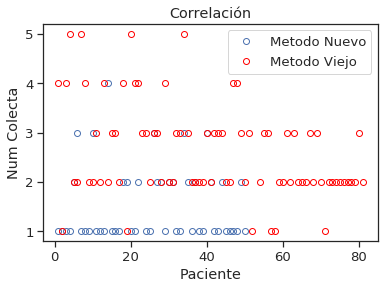

In [14]:
fig_corr, ax = plt.subplots()
x_new = df_NewMeth.index
y_new = df_NewMeth['Num_Colecta']

x_old = df_OldMeth.index
y_old = df_OldMeth['Num_Colecta']

ax.set_xlabel('Paciente')
ax.set_ylabel('Num Colecta')

c = plt.get_cmap('tab20c_r')

ax.plot(x_new,y_new,
        marker='o',mfc='none',ls='none',
#         cmap=c,
        label='Metodo Nuevo')
# ax.set_label('Metodo Nuevo')
ax.plot(x_old,y_old,label='Metodo Viejo',
          marker='o',mfc='none',ls='none',
          color='Red')
ax.set_title('Correlación')
ax.legend()


In [15]:
# -- Compute autocorrelations
y_new_aux = (y_new - y_new.mean())/y_new.size
Cr_new = correlate(y_new_aux,y_new_aux,mode='full')
Cr_new = Cr_new[int(Cr_new.size/2):]

y_old_aux = (y_old - y_old.mean())/y_old.size
Cr_old = correlate(y_old_aux,y_old_aux,mode='full')
Cr_old = Cr_old[int(Cr_old.size/2):]

In [16]:
# -- Get tau for each curve
from scipy.optimize import curve_fit

def f(x,tau,a,b):
    return a*np.exp(-x/tau)+b

fit_N_popt, _ = curve_fit(f,xdata=x_new,ydata=Cr_new,p0=[1,1,0],maxfev=2000)

fit_O_popt, _ = curve_fit(f,xdata=x_old,ydata=Cr_old,p0=[1,1,0],maxfev=2000)

In [17]:
print(fit_N_popt)
Gr_fit_N = f(x_new,fit_N_popt[0],fit_N_popt[1],fit_N_popt[2])
Gr_fit_O = f(x_old,fit_O_popt[0],fit_O_popt[1],fit_O_popt[2])
# plt.plot(x_new,y)
print(fit_O_popt)

[ 8.21117197e-02  2.30930534e+03 -1.22363578e-04]
[ 3.59751791e-01  1.90132420e-01 -8.40176361e-05]


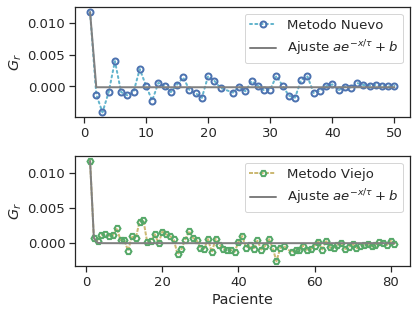

In [81]:
fig_corr_len, ax_corr = plt.subplots(2,1)
plt.subplots_adjust(bottom=0.05,top=.95,hspace=0.35)

ax_corr[0].plot(x_new,Cr_new,label='Metodo Nuevo',
                    color='c',
                    dash_capstyle='round',ls=':',
                    marker='o',mec='b',mew=2,mfc='none',
            )
ax_corr[0].plot(x_new,Gr_fit_N,label=r'Ajuste $a e^{-x/\tau}+b$',
                    color='Grey',
                    dash_capstyle='round',ls='-'
            )

ax_corr[1].plot(x_old,Cr_old,label='Metodo Viejo',
                    color='y',
                    dash_capstyle='projecting',ls=':',
                    marker='H',mec='g',mew=2,mfc='none'
            )
ax_corr[1].plot(x_old,Gr_fit_O,label=r'Ajuste $a e^{-x/\tau}+b$',
                    color='Grey',
                    dash_capstyle='round',ls='-'
            )

# ax_corr[0].set_xlabel('Paciente')
ax_corr[1].set_xlabel('Paciente')

ax_corr[0].set_ylabel('$G_r$')
ax_corr[1].set_ylabel('$G_r$')

ax_corr[0].legend()
ax_corr[1].legend()

plt.show()
# plt.savefig('acorr_samples.png')

In [19]:
print(f'Para la muestra del Nuevo metodo vemos que tau = {Gr_fit_N[0]}')
print(f'Para la muestra del Viejo metodo vemos que tau = {Gr_fit_O[0]}')

Para la muestra del Nuevo metodo vemos que tau = 0.011746611154178231
Para la muestra del Viejo metodo vemos que tau = 0.011715120432888046


**Luego ambas muestras se conforman de medidas independientes.**

## Descriptive Statistics

In [20]:
# -- Get the actual histogram to compute operations
old_colect = df_OldMeth['Num_Colecta'].to_numpy()
new_colect = df_NewMeth['Num_Colecta'].to_numpy()

In [21]:
# -- Get size of sample, mean, and standard deviation
N_old = old_colect.size
mean_old = np.round(old_colect.mean(),2)
std_old = np.round(old_colect.std(),2)

In [22]:
# print(N_old,mean_old,std_old)
print('For the Old Method \n',f'sample size: {N_old}','\n',f'mean: {mean_old}','\n',f'standar_dev: {std_old}')

For the Old Method 
 sample size: 80 
 mean: 2.61 
 standar_dev: 0.97


In [23]:
# -- Get size of sample, mean, and standard deviation
N_new = new_colect.size
mean_new = np.round(new_colect.mean(),2)
std_new = np.round(new_colect.std(),2)

In [24]:
# print(N_old,mean_old,std_old)
print('For the New Method \n', f'sample size: {N_new}','\n',f'mean: {mean_new}','\n',f'standar_dev: {std_new}')

For the New Method 
 sample size: 49 
 mean: 1.53 
 standar_dev: 0.76


In [25]:
def norm_dist(x,mean,sigma,A=1):
    nom= (x - mean)**2
    den= 2*sigma**2
    return (A/(sigma*2*np.pi))*np.exp(-nom/den)


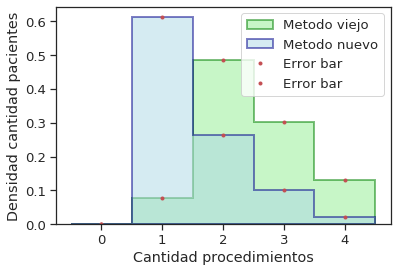

In [88]:
# TODO: Add norm dist on top of samples.
fig, ax = plt.subplots()

bins = np.arange(6) - 0.5

style_dict_1 = {
                'density':True,            #--> normalized histogram
                'align':'mid',             #--> place ticks in the middle
                'histtype':'stepfilled',   #--> type
#                 'color':'DarkBlue',        #--> linecolor
                'linestyle':'-',          
                'linewidth':2,
                'alpha':0.5,               #--> how strong the shading of the filling is
                'edgecolor':'DarkBlue',
                'facecolor':'LightBlue',   #--> color of the shading
                }



nlib.mhist(ax,old_colect,bins=bins,label='Metodo viejo',style_dict=style_dict_6)
nlib.mhist(ax,new_colect,bins=bins,label='Metodo nuevo',style_dict=style_dict_1)

x = np.linspace(start=-1,stop=5,num=100)
# sgmN = (std_new/np.sqrt(N_new))**2
sgmN = std_new**2/N_new
sgmO = std_old**2/N_old


# popul_N = norm_dist(x,mean_new,sgmN,A=0.15)
# popul_O = norm_dist(x,mean_old,sgmO,A=0.9)
# ax.plot(x,popul_N,label='Dist. population New')
# ax.plot(x,popul_O,label='Dist. population Old')

ax.set_xlabel('Cantidad procedimientos')
ax.set_ylabel('Densidad cantidad pacientes')

ax.legend()

## Hypothesis Testing

Dado que el objetivo es evaluar si el método nuevo emplea menos procedimientos con respecto al método viejo,
nos centramos en el valor medio de procedimientos ($\mu^{proc}$).
Dado que son muestras tomadas de medidas independientes podemos afirmar que la distribución de la población es aproximadamente gaussiana, luego la pregunta se torna en evaluar si las muestras provienen de la misma población o no.

Definimos la _Hipótesis Nula_ :

\begin{equation}
H_0 = \mu_{new}^{proc} \ge \mu_{old}^{proc}
\end{equation}

Definimos la _Hipótesis Alternativa_ :
\begin{equation}
H_A = \mu_{new}^{proc} < \mu_{old}^{proc}
\end{equation}

La función que utilizaré define la hipótesis nula para un t-test de 2 colas de la siguiente manera:

\begin{equation}
H_0 = \mu_{1}^{proc} - \mu_{2}^{proc} = 0
\end{equation}


Donde los indices $1$ y $2$ corresponden a la etiqueta de la muestra, y por lo tanto a la hora de pasar esta información a la función el _**orden**_ de las muestras _**es importante**_

Debido a la naturaleza de la comparación de valores medios de la muestra,
corresponde realizar un test de student (t-test) a izquierda.
Para ello tomamos el nivel de significancia $\alpha = 0.01$

In [27]:
# --computing T-Test from sample
statistics1, p_value1 = stats.ttest_ind(new_colect,old_colect, axis=0, equal_var=True, nan_policy='propagate')

In [28]:
print(f'statistic = {np.round(statistics1,2)}')
print(f'el p_valor_colect es {np.format_float_scientific(p_value1, precision=0)}')

statistic = -6.62
el p_valor_colect es 9.e-10


## Conclusion

Vemos que el valor del test es negativo, lo cual indica que estamos en la cola izquierda como deseabamos.

Como resultado vemos que el $p_{valor} \le \alpha$ por $6$ ordenes de magnitud,
por lo tanto corresponde rechazar la hipótesis nula y en consecuencia aceptar la hipótesis alternativa.
De esta manera hemos demostrado que el método nuevo utiliza menos procedimientos que el método viejo con un nivel de confianza superior al $99 \%$. 

Como corolario podemos afirmar que:

In [29]:
mean_new_err = np.round(std_new/np.sqrt(new_colect.size),2)
mean_old_err = np.round(std_new/np.sqrt(old_colect.size),2)
print(f'El nuevo metodo emplea {mean_new}({mean_new_err}) procedimientos')
print(f'El viejo metodo emplea {mean_old}({mean_old_err}) procedimientos')

El nuevo metodo emplea 1.53(0.11) procedimientos
El viejo metodo emplea 2.61(0.08) procedimientos


In [30]:
# TODO:: plots of N-dist for those values

# Volumen - Analisis 2

## Descriptive Statistics

In [31]:
# -- Get the actual histogram to compute operations
old_vol = df_OldMeth['Volumen [ml]'].to_numpy()
new_vol = df_NewMeth['Volumen [ml]'].to_numpy()

In [32]:
# -- Get size of sample, mean, and standard deviation
N2_old = old_vol.size
mean2_old = np.round(old_vol.mean(),2)
std2_old = np.round(old_vol.std(),2)

In [33]:
# print(N_old,mean_old,std_old)
print('For the Old Method \n',f'sample size: {N2_old}','\n',f'mean: {mean2_old}','\n',f'standar_dev: {std2_old}')

For the Old Method 
 sample size: 80 
 mean: 676.16 
 standar_dev: 311.19


In [34]:
# -- Get size of sample, mean, and standard deviation
N2_new = new_vol.size
mean2_new = np.round(new_vol.mean(),2)
std2_new = np.round(new_vol.std(),2)

In [35]:
# print(N_old,mean_old,std_old)
print('For the New Method \n', f'sample size: {N2_new}','\n',f'mean: {mean2_new}','\n',f'standar_dev: {std2_new}')

For the New Method 
 sample size: 49 
 mean: 452.55 
 standar_dev: 397.39


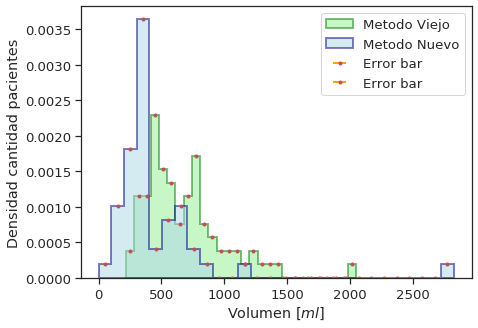

In [89]:
fig, ax = plt.subplots(figsize=(7,5))

bins = 28


nlib.mhist(ax,old_vol,bins=bins,label='Metodo Viejo',xerr=1,style_dict=style_dict_6)
nlib.mhist(ax,new_vol,bins=bins,label='Metodo Nuevo',xerr=1,style_dict=style_dict_1)

ax.set_xlabel(f'Volumen [$ml$]')
# ax.get_xaxis().set_units('ml')
ax.set_ylabel('Densidad cantidad pacientes')

ax.legend()

## Hypothesis Testing

Dado que el objetivo es evaluar si el método nuevo emplea menos volumen con respecto al método viejo,
nos centramos en el valor medio de procedimientos ($\mu^{V}$).
Dado que son muestras tomadas de medidas independientes podemos afirmar que la distribución de la población es aproximadamente gaussiana, luego la pregunta se torna en evaluar si las muestras provienen de la misma población o no.

Definimos la _Hipótesis Nula_ :

\begin{equation}
H_0 = \mu_{new}^{V} \ge \mu_{old}^{V}
\end{equation}

Definimos la _Hipótesis Alternativa_ :
\begin{equation}
H_A = \mu_{new}^{V} < \mu_{old}^{V}
\end{equation}

Debido a la naturaleza de la comparación de valores medios de la muestra,
corresponde realizar un test de student (t-test) a izquierda.
Para ello tomamos el nivel de significancia $\alpha = 0.05$

In [37]:
# --computing T-Test from sample
statistics2, p_value2 = stats.ttest_ind(new_vol,old_vol, axis=0, equal_var=True, nan_policy='propagate')

In [38]:
print(f'statistics = {np.round(statistics2,2)}')
print(f'el p_valor_vol es {np.format_float_scientific(p_value2, precision=0)}')

statistics = -3.53
el p_valor_vol es 6.e-04


In [39]:
def test_res(alpha,pvalue):
    if pvalue <= alpha:
        print(f'Reject Null Hypothesis $H_0$, therefore accept Alternative Hypothesis $H_A$')
    else:
        print(f'Failed to reject Null Hypothesis $H_0$')

In [40]:
test_res(0.01,p_value2)

Reject Null Hypothesis $H_0$, therefore accept Alternative Hypothesis $H_A$


In [41]:
mean2_new_err = np.round(std2_new/np.sqrt(new_vol.size),0)
mean2_old_err = np.round(std2_new/np.sqrt(old_vol.size),0)
print(f'El nuevo metodo requiere {mean2_new}({mean2_new_err}) volumen')
print(f'El viejo metodo requiere {mean2_old}({mean2_old_err}) volumen')

El nuevo metodo requiere 452.55(57.0) volumen
El viejo metodo requiere 676.16(44.0) volumen


In [42]:
def propagate_err_percent(X1,X2,ErrX1,ErrX2):
    term1 = ErrX1/X2
    term2 = X1*ErrX2/(X2**2)
    err = np.sqrt(term1**2 + term2**2)
    return err

In [43]:
propagate_err_percent(452,676,57,44)

0.09488861898317275

In [44]:
propagate_err_percent(1.53,2.61,.11,.08)

0.04581594803311213

## Conclusion

Como resultado vemos que el $p_{valor} \le \alpha$ por $2$ ordenes de magnitud,
por lo tanto corresponde rechazar la hipótesis nula y en consecuencia aceptar la hipótesis alternativa.
De esta manera hemos demostrado que el método nuevo utiliza menos procedimientos que el método viejo con un nivel de confianza superior al $95 \%$, pero a la luz de los resultados podríamos obtener un nivel de confianza superior al $99 \%$. 

--- 

## DataCleaning - TRASPLANTES.xlsx

In [45]:
# -- Load data to data frames from TRANSPLANTES
with open(transp_file, 'rb') as file:
    # --Reading sheet to get oldmethod sample
    df2_OldMeth = pd.read_excel(
        file,
        sheet_name='TRASPLANTE_METODO_VIEJO',
        header=0,
        index_col='TRASPLANTE'
    )
    df2_OldMeth.index.name = 'Paciente'

    # --Reading sheet to get newmethod sample
    df2_NewMeth = pd.read_excel(
        file,
        sheet_name='TRASPLANTE_METODO_NUEVO',
        header=0,
        index_col='PACIENTE'
    )
    df2_NewMeth.index.name = 'Paciente'
    
def rename_cols(DataFrame):
    DataFrame.columns = [
        'Patologia','Internacion [dias]','Fiebre [dias]',
        'Glob.B > 0.5k [dias]','Glob.B > 1k [dias]','Plaq > 25k [dias]','Plaq > 50k [dias]',
        'Nota'
    ]
    DataFrame = DataFrame[['Patologia',
                           'Fiebre [dias]',
                           'Glob.B > 0.5k [dias]',
                           'Glob.B > 1k [dias]',
                           'Plaq > 25k [dias]',
                           'Plaq > 50k [dias]',
                           'Internacion [dias]',
                           'Nota']]
    
    return
 

In [46]:
# --Renaming columns
rename_cols(df2_OldMeth)
rename_cols(df2_NewMeth)

df2_NewMeth.drop(columns='Nota')
df2_OldMeth.drop(columns='Nota')

,Patologia,Internacion [dias],Fiebre [dias],Glob.B > 0.5k [dias],Glob.B > 1k [dias],Plaq > 25k [dias],Plaq > 50k [dias]
Paciente,,,,,,,
1,TCG,25,2,12,13,17,25
2,MM,17,10,9,9,10,11
3,EH,ND,ND,ND,ND,ND,ND
4,MM,13,0,10,11,12,12
5,MM,20,0,10,10,10,11
...,...,...,...,...,...,...,...
57,EH,NO SE TRASPLANTO,NaN,NaN,NaN,NaN,NaN
58,EH,24,1,9,10,14,20
59,EH,23,2,10,10,12,17


Fixing values

In [47]:
df2_NewMeth.loc[1,'Patologia'] = 'LMA'

In [48]:
def serch_unique(DataFrame):
    unique_val = {col:DataFrame[col].unique() for col in DataFrame.columns}
    return unique_val

In [49]:
# unique_val

In [50]:
# --Search for unique values
NM_uniquevalues = serch_unique(df2_NewMeth)
OM_uniquevalues = serch_unique(df2_OldMeth)

In [51]:
print(f'----Metodo Viejo NaNs----')
print(OM_uniquevalues)
print('\n')
print(f'----Metodo Nuevo NaNs----')
print(NM_uniquevalues)

----Metodo Viejo NaNs----
{'Patologia': array(['TCG', 'MM', 'EH', 'LNH', 'LMA', 'LMC', 'LNH DEL MANTO', 'LLA'],
      dtype=object), 'Internacion [dias]': array([25, 17, 'ND', 13, 20, 29, 34, 22, 18, 72, 23, 32, 14, 21, 16,
       'NO SE TRASPLANTO', 38, 37, 10, 30, 24, 15, 31, 50, 156, 48, 19,
       35, ' NO SE TRASPLANTO', 11, 42, 27], dtype=object), 'Fiebre [dias]': array([2, 10, 'ND', 0, 3, 1, 7, 5, nan, 18, 4, 13], dtype=object), 'Glob.B > 0.5k [dias]': array([12, 9, 'ND', 10, 13, 8, 6, 11, 14, 16, 7, nan, 15, 19, 'NO', 17],
      dtype=object), 'Glob.B > 1k [dias]': array([13, 9, 'ND', 11, 10, 14, 6, 12, 22, nan, 17, 15, 16, 'NO', 19],
      dtype=object), 'Plaq > 25k [dias]': array([17, 10, 'ND', 12, 13, 14, 9, 5, 15, 21, 28, 20, 11, nan, 19, 16,
       27, 64, 8, 34, 23, 'NO', 25], dtype=object), 'Plaq > 50k [dias]': array([25, 11, 'ND', 12, 14, 39, 5, 32, 21, 65, 10, 19, 30, 15, nan, 18,
       13, 35, 24, 16, 33, 99, 48, 28, 649, 'NO', 9, 20, 17], dtype=object), 'Nota': arra

In [52]:
def fill_with_nan(DataFrame,to_replace,from_col,to_col=None):
    if to_col == None: to_col = len(DataFrame.columns)
    for col in DataFrame.columns[from_col:to_col]:
        DataFrame.loc[:,col].replace(
            to_replace=to_replace,
            value=np.NaN,
            inplace=True
        )

In [53]:
# -- Replace all non standar NaN values for np.NaN
fill_with_nan(df2_OldMeth,'ND',1)
fill_with_nan(df2_NewMeth,'ND',1)

fill_with_nan(df2_OldMeth,'NO',1)
fill_with_nan(df2_NewMeth,'NO',1)

fill_with_nan(df2_OldMeth,r'\s+NO SE TRASPLANTO',1)
fill_with_nan(df2_NewMeth,r'\s+NO\s+SE\s+TRASPLANTO\s+',0)

In [54]:
# Delete useless row
filt = df2_NewMeth.loc[:,'Internacion [dias]'] == 'NO SE TRASPLANTO'
del_idx= df2_NewMeth[filt].index
df2_NewMeth.drop(index=del_idx,inplace=True)

filt = df2_OldMeth.loc[:,'Internacion [dias]'] == 'NO SE TRASPLANTO'
del_idx= df2_OldMeth[filt].index
df2_OldMeth.drop(index=del_idx,inplace=True)


df2_OldMeth.drop(index=48,inplace=True)

In [55]:
# Fix the types of each column

df2_NewMeth = df2_NewMeth.convert_dtypes(convert_integer=False,convert_boolean=False)
df2_OldMeth = df2_OldMeth.convert_dtypes(convert_integer=False,convert_boolean=False)

print(df2_NewMeth.dtypes)
print()
print(df2_OldMeth.dtypes)

Patologia                string
Internacion [dias]        int64
Fiebre [dias]           float64
Glob.B > 0.5k [dias]    float64
Glob.B > 1k [dias]      float64
Plaq > 25k [dias]       float64
Plaq > 50k [dias]       float64
Nota                     string
dtype: object

Patologia                string
Internacion [dias]      float64
Fiebre [dias]           float64
Glob.B > 0.5k [dias]    float64
Glob.B > 1k [dias]      float64
Plaq > 25k [dias]       float64
Plaq > 50k [dias]       float64
Nota                     string
dtype: object


In [56]:
NM_uniquevalues = serch_unique(df2_NewMeth)
OM_uniquevalues = serch_unique(df2_OldMeth)

In [57]:
print(f'----Metodo Viejo NaNs----')
print(OM_uniquevalues)
print('\n')
print(f'----Metodo Nuevo NaNs----')
print(NM_uniquevalues)
# TODO: fixed repeted unique values
df2_NewMeth['Patologia'].replace(to_replace='MM ',value='MM',inplace=True)


----Metodo Viejo NaNs----
{'Patologia': <StringArray>
['TCG', 'MM', 'EH', 'LNH', 'LMA', 'LMC', 'LNH DEL MANTO', 'LLA']
Length: 8, dtype: string, 'Internacion [dias]': array([ 25.,  17.,  nan,  13.,  20.,  29.,  34.,  22.,  18.,  72.,  23.,
        32.,  14.,  21.,  16.,  38.,  37.,  10.,  30.,  24.,  15.,  31.,
        50., 156.,  48.,  19.,  35.,  11.,  42.,  27.]), 'Fiebre [dias]': array([ 2., 10., nan,  0.,  3.,  1.,  7.,  5., 18.,  4., 13.]), 'Glob.B > 0.5k [dias]': array([12.,  9., nan, 10., 13.,  8.,  6., 11., 14., 16.,  7., 15., 19.,
       17.]), 'Glob.B > 1k [dias]': array([13.,  9., nan, 11., 10., 14.,  6., 12., 22., 17., 15., 16., 19.]), 'Plaq > 25k [dias]': array([17., 10., nan, 12., 13., 14.,  9.,  5., 15., 21., 28., 20., 11.,
       19., 16., 27., 64.,  8., 34., 23., 25.]), 'Plaq > 50k [dias]': array([ 25.,  11.,  nan,  12.,  14.,  39.,   5.,  32.,  21.,  65.,  10.,
        19.,  30.,  15.,  18.,  13.,  35.,  24.,  16.,  33.,  99.,  48.,
        28., 649.,   9.,  20.,  17

In [58]:
# -- count NaN by cols
NM_NaNs=df2_NewMeth.isna().sum()
OM_NaNs=df2_OldMeth.isna().sum()

print(f'----Metodo Viejo NaNs----')
print(OM_NaNs)
print('\n')
print(f'----Metodo Nuevo NaNs----')
print(NM_NaNs)

filt = df2_OldMeth.loc[:,'Internacion [dias]'].isna()
df2_OldMeth[filt]

----Metodo Viejo NaNs----
Patologia                0
Internacion [dias]       1
Fiebre [dias]            1
Glob.B > 0.5k [dias]     2
Glob.B > 1k [dias]       2
Plaq > 25k [dias]        2
Plaq > 50k [dias]        2
Nota                    57
dtype: int64


----Metodo Nuevo NaNs----
Patologia                0
Internacion [dias]       0
Fiebre [dias]            0
Glob.B > 0.5k [dias]     2
Glob.B > 1k [dias]       2
Plaq > 25k [dias]        3
Plaq > 50k [dias]        3
Nota                    39
dtype: int64


,Patologia,Internacion [dias],Fiebre [dias],Glob.B > 0.5k [dias],Glob.B > 1k [dias],Plaq > 25k [dias],Plaq > 50k [dias],Nota
Paciente,,,,,,,,
3,EH,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


# Tiempos de recuperacion - Analisis 3

In [59]:
df2_NewMeth.tail()

,Patologia,Internacion [dias],Fiebre [dias],Glob.B > 0.5k [dias],Glob.B > 1k [dias],Plaq > 25k [dias],Plaq > 50k [dias],Nota
Paciente,,,,,,,,
39,LNH DEL MANTO,31,1.0,11.0,11.0,16.0,21.0,<NA>
40,LNH DEL MANTO,19,1.0,9.0,10.0,13.0,16.0,<NA>
41,LLA,26,1.0,11.0,17.0,9.0,15.0,<NA>
42,LMA,37,5.0,15.0,16.0,13.0,21.0,<NA>
43,LNH DEL MANTO,36,2.0,9.0,9.0,12.0,14.0,<NA>


In [60]:
filt =df2_OldMeth.loc[:,'Plaq > 25k [dias]']>30

df2_OldMeth[filt]

,Patologia,Internacion [dias],Fiebre [dias],Glob.B > 0.5k [dias],Glob.B > 1k [dias],Plaq > 25k [dias],Plaq > 50k [dias],Nota
Paciente,,,,,,,,
39,LMA,31.0,0.0,14.0,15.0,64.0,99.0,<NA>
42,LNH,48.0,10.0,11.0,11.0,34.0,48.0,<NA>


## Time_Avg by patient

In [61]:
# --function for wedge format
def func(pct, allvals):
    # -- pct:: the percentage
    absolute = int(pct/100.*np.sum(allvals))
    return "{:d}($\pm$1)\n{:.1f}%".format(absolute,pct)

[Text(1.1108070568462283, -0.4797996274077549, 'EH'), Text(1.171702646597778, 0.3020147479110298, 'LLA'), Text(0.5377541828366282, 1.0839374699869502, 'LMA'), Text(-0.497657475923267, 1.1029220446875125, 'LMC'), Text(-1.1108071017683068, 0.47979952340649024, 'LNH'), Text(-1.1541308078406247, -0.3634309816088156, 'LNH DEL MANTO'), Text(-0.7149477682945091, -0.9761914200661167, 'LNHT'), Text(-0.14164731205302725, -1.2016805062029394, 'MM'), Text(0.42383421145057704, -1.133342208339594, 'SMD'), Text(0.8046240715706102, -0.9037035484323019, 'TCG')]


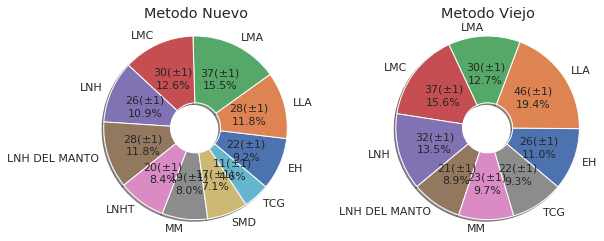

In [62]:
cols = ['Patologia','Internacion [dias]']
N_pato = df2_NewMeth.loc[:,cols].groupby(by='Patologia').mean()
N_pato = np.round(N_pato)

O_pato = df2_OldMeth.loc[:,cols].groupby(by='Patologia').mean()
O_pato = np.round(O_pato)


# TODO emprolijar y agregar std
# plt.pie(x=N_pato['Internacion [dias]'],labels=N_pato.index)
fig_pie, ax_pie = plt.subplots(1,2,figsize=(7,5))

N_data = N_pato['Internacion [dias]']
O_data = O_pato['Internacion [dias]']

N_labels = N_pato.index
O_labels = O_pato.index

N_labels = N_labels.tolist()


pie_style = {'shadow':True,
             'autopct':lambda pct: func(pct, N_data),
             'radius':1.1,
             'wedgeprops':{'width':0.8,'edgecolor':'w'},
             'textprops':{'size':11},
             'rotatelabels':False,
             'startangle':-40,
            }


_,text,_ = nlib.mpie(ax=ax_pie[0],
          data=N_data,
          labels=N_labels,
          title='Metodo Nuevo',
          style_dict=pie_style
    )


_,textO,_ = nlib.mpie(ax=ax_pie[1],
          data=O_data,
          labels=O_labels,
          title='Metodo Viejo',
          style_dict=pie_style
    )


print(text)



ax_pie[0].set_aspect('equal')
ax_pie[1].set_aspect('equal')
# ax_pie.legend(loc='center right')
# print(N_pato)

# fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
# wedges, texts = ax.pie(N_data, wedgeprops=dict(width=0.5), startangle=-40)

# # --set format for labels
# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle='-'),
#           bbox=bbox_props, zorder=0, va="center")

# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(N_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                 horizontalalignment=horizontalalignment, **kw)
    
# plt.setp(autotexts)

plt.subplots_adjust(left=0.0015,right=0.995,wspace=0.4)

plt.show()

## Patient evolution

Text(0.5, 1.0, 'Internacion')

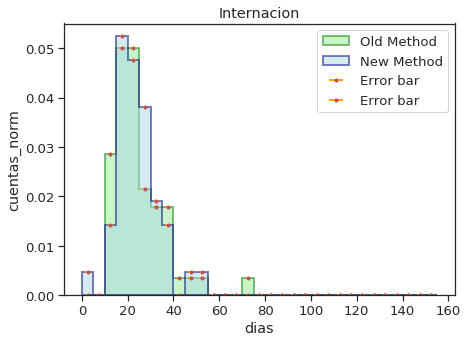

In [90]:
fig_int, ax = plt.subplots(figsize=(7,5))

new_inter = df2_NewMeth['Internacion [dias]']
old_inter = df2_OldMeth['Internacion [dias]']

# print(old_inter)
min_bin = min(new_inter)
max_bin = max(new_inter)
max_bin = max(old_inter)
# print(max_bin,min_bin)

bins = np.arange(start=0,stop=max_bin,step=5)

xerr=1



nlib.mhist(ax,old_inter,bins=bins,xerr=xerr,
           label='Old Method',style_dict=style_dict_6)
nlib.mhist(ax,new_inter,bins=bins,xerr=xerr,
           label='New Method',style_dict=style_dict_1)
ax.set_xlabel('dias')

ax.set_ylabel('cuentas_norm')
ax.legend()
ax.set_title('Internacion')
# fig.title()
# ax.pie(x=df2_NewMeth.index,labels=df2_NewMeth['Patologia'])

### Globulos blancos

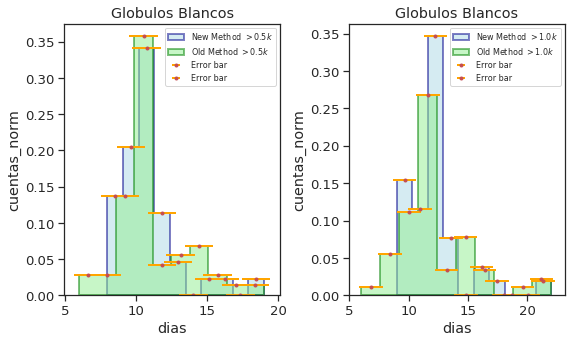

In [91]:
fig_GB, ax = plt.subplots(1,2,figsize=(7,5))
new_GB05=df2_NewMeth['Glob.B > 0.5k [dias]']
old_GB05=df2_OldMeth['Glob.B > 0.5k [dias]']

new_GB10=df2_NewMeth['Glob.B > 1k [dias]']
old_GB10=df2_OldMeth['Glob.B > 1k [dias]']

xerr=1

nlib.mhist(ax[0],new_GB05,bins=None,xerr=xerr,
           label='New Method $> 0.5$$k$',style_dict=style_dict_1)
nlib.mhist(ax[0],old_GB05,bins=None,xerr=xerr,
           label='Old Method $> 0.5$$k$',style_dict=style_dict_6)

nlib.mhist(ax[1],new_GB10,bins=None,xerr=xerr,
           label='New Method $> 1.0$$k$',style_dict=style_dict_1)
nlib.mhist(ax[1],old_GB10,bins=None,xerr=xerr,
           label='Old Method $> 1.0$$k$',style_dict=style_dict_6)


for axes in ax:
    axes.set_xlabel('dias')
    axes.set_ylabel('cuentas_norm')
    axes.legend(loc='best',prop={'size': 8})
    axes.set_title('Globulos Blancos')

# ax[1].set_xlabel('dias')
# ax[1].set_ylabel('cuentas_norm')
# ax[1].legend(loc='best',prop={'size': 8})
# ax[1].set_title('Globulos Blancos')


plt.subplots_adjust(left=0.0015,right=0.995,wspace=0.32)

Definimos la _Hipótesis Nula_ :

\begin{equation}
H_0 = \mu_{new}^{GB} > \mu_{old}^{GB}
\end{equation}

Definimos la _Hipótesis Alternativa_ :
\begin{equation}
H_A = \mu_{new}^{GB} \le \mu_{old}^{GB}
\end{equation}

Realizamos nuevamente los t-test para estas muestras con significancia $\alpha = 0.05$.

In [65]:
old_GB05.dropna(inplace=True)
new_GB05.dropna(inplace=True)

old_GB10.dropna(inplace=True)
new_GB10.dropna(inplace=True)

In [66]:
# --computing T-Test from sample
statsGB05, p_valueGB05 = stats.ttest_ind(new_GB05,old_GB05, axis=0, equal_var=True, nan_policy='raise')
statsGB10, p_valueGB10 = stats.ttest_ind(new_GB10,old_GB10, axis=0, equal_var=True, nan_policy='raise')

In [67]:
print(f'GB05: statistics = {np.round(statsGB05,2)}')
print(f'GB05: el p_valor_vol es {np.format_float_scientific(p_valueGB05, precision=0)}')
print()
print(f'GB10: statistics = {np.round(statsGB10,2)}')
print(f'GB10: el p_valor_vol es {np.format_float_scientific(p_valueGB10, precision=0)}')

GB05: statistics = 0.13
GB05: el p_valor_vol es 9.e-01

GB10: statistics = 0.0
GB10: el p_valor_vol es 1.e+00


## Conclusion

Para ambas muestras de Globulos Blancos fallamos en rechazar la hipotesis nula por falta de significancia.
Para la muestra $>0.5$$k$ el $p_{valor}$ equivalente para el test a izquierda es $0.8 > 0.05$.


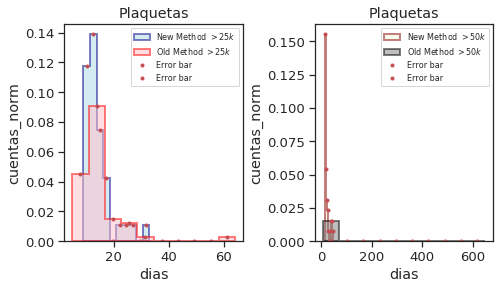

In [68]:
fig_GB, ax = plt.subplots(1,2)
new_P25=df2_NewMeth['Plaq > 25k [dias]']
old_P25=df2_OldMeth['Plaq > 25k [dias]']

new_P50=df2_NewMeth['Plaq > 50k [dias]']
old_P50=df2_OldMeth['Plaq > 50k [dias]']

nlib.mhist(ax[0],new_P25,bins=None,label='New Method $> 25$$k$')
nlib.mhist(ax[0],old_P25,bins=None,label='Old Method $> 25$$k$',style_dict=style_dict_2)


nlib.mhist(ax[1],new_P50,bins=None,label='New Method $> 50$$k$',style_dict=style_dict_4)
nlib.mhist(ax[1],old_P50,bins=None,label='Old Method $> 50$$k$',style_dict=style_dict_3)


for axes in ax:
    axes.set_xlabel('dias')
    axes.set_ylabel('cuentas_norm')
    axes.legend(loc='best',prop={'size': 8})
    axes.set_title('Plaquetas')


plt.subplots_adjust(left=0.0015,right=0.995,wspace=0.4)

In [69]:
cols =['Glob.B > 0.5k [dias]','Glob.B > 1k [dias]','Plaq > 25k [dias]','Plaq > 50k [dias]','Internacion [dias]']

df2_OldMeth[cols].astype(dtype='float64')


pdf = df2_OldMeth['Plaq > 50k [dias]']
avg = pdf.mean()
# calc = avg+5*std
pdf.mask(pdf > 3*avg, inplace=True)

avg_recov_NM = np.round(df2_NewMeth.loc[:,cols].mean())
std_recov_NM = np.round(df2_NewMeth.loc[:,cols].std())

print(avg_recov_NM,std_recov_NM)
print()


avg_recov_OM = np.round(df2_OldMeth.loc[:,cols].mean())
std_recov_OM = np.round(df2_OldMeth.loc[:,cols].std())

print(avg_recov_OM,std_recov_OM)

# print(len(cols),len(avg_recov_NM),len(avg_recov_OM))

Glob.B > 0.5k [dias]    11.0
Glob.B > 1k [dias]      12.0
Plaq > 25k [dias]       14.0
Plaq > 50k [dias]       20.0
Internacion [dias]      24.0
dtype: float64 Glob.B > 0.5k [dias]    2.0
Glob.B > 1k [dias]      2.0
Plaq > 25k [dias]       5.0
Plaq > 50k [dias]       8.0
Internacion [dias]      9.0
dtype: float64

Glob.B > 0.5k [dias]    11.0
Glob.B > 1k [dias]      12.0
Plaq > 25k [dias]       15.0
Plaq > 50k [dias]       18.0
Internacion [dias]      27.0
dtype: float64 Glob.B > 0.5k [dias]     3.0
Glob.B > 1k [dias]       3.0
Plaq > 25k [dias]        9.0
Plaq > 50k [dias]       11.0
Internacion [dias]      21.0
dtype: float64


In [70]:
# -- We need to mask some values

avg = avg_recov_OM['Plaq > 50k [dias]']
std = std_recov_OM['Plaq > 50k [dias]']
# df2_OldMeth.mask(cond=None,inplace=True)
pdf = df2_OldMeth['Plaq > 50k [dias]']
calc = avg+5*std
pdf.mask(pdf > calc, inplace=True)

# print(df2_OldMeth['Plaq > 50k [dias]'], pdf)

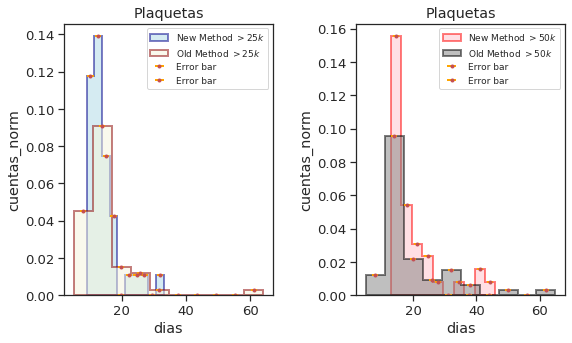

In [71]:
# -- Draw histos for plaquetas

fig_GB, ax = plt.subplots(1,2,figsize=(7,5))
new_P25=df2_NewMeth['Plaq > 25k [dias]']
old_P25=df2_OldMeth['Plaq > 25k [dias]']

new_P50=df2_NewMeth['Plaq > 50k [dias]']
old_P50=df2_OldMeth['Plaq > 50k [dias]']

nlib.mhist(ax[0],new_P25,bins=None,xerr=xerr,
           label='New Method $> 25$$k$')
nlib.mhist(ax[0],old_P25,bins=None,xerr=xerr,
           label='Old Method $> 25$$k$',style_dict=style_dict_4)


nlib.mhist(ax[1],new_P50,bins=None,xerr=xerr,
           label='New Method $> 50$$k$',style_dict=style_dict_2)
nlib.mhist(ax[1],old_P50,bins=None,xerr=xerr,
           label='Old Method $> 50$$k$',style_dict=style_dict_3)


for axes in ax:
    axes.set_xlabel('dias')
    axes.set_ylabel('cuentas_norm')
    axes.legend(loc='best',prop={'size': 9})
    axes.set_title('Plaquetas')


plt.subplots_adjust(left=0.0015,right=0.995,wspace=0.4)

### Hypotesis testing for plaquetas samples

In [72]:
# --computing T-Test from sample
statsP25, p_valueP25 = stats.ttest_ind(new_P25,old_P25, axis=0, equal_var=True, nan_policy='omit')
statsP50, p_valueP50 = stats.ttest_ind(new_P50,old_P50, axis=0, equal_var=True, nan_policy='omit')

In [73]:
print(f'P25: statistics = {np.round(statsP25,2)}')
print(f'P25: el p_valor_vol es {np.format_float_scientific(p_valueP25, precision=0)}')
print()
print(f'P50: statistics = {np.round(statsP50,2)}')
print(f'P50: el p_valor_vol es {np.format_float_scientific(p_valueP50, precision=0)}')

P25: statistics = -0.24
P25: el p_valor_vol es 8.e-01

P50: statistics = 0.61
P50: el p_valor_vol es 5.e-01


([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

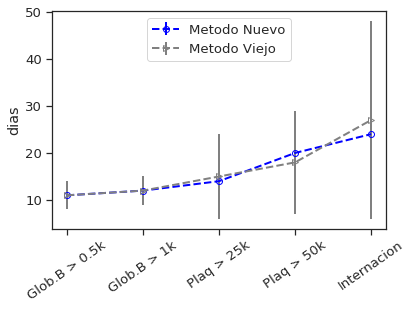

In [74]:
fig, ax = plt.subplots()
labels=['Glob.B > 0.5k','Glob.B > 1k','Plaq > 25k','Plaq > 50k', 'Internacion']

nlib.mplot(ax,x=labels,y=avg_recov_NM,
           label='Metodo Nuevo',
           yerr=std_recov_NM,xerr=0)

style = {'marker':'>',
         'mfc':'none',
         'color':'grey',
         'linestyle':'--'
        }
nlib.mplot(ax,x=labels,y=avg_recov_OM,
           label='Metodo Viejo',
           yerr=std_recov_OM,xerr=0,
           style_dict=style)

ax.legend(loc='upper center')
ax.set_ylabel('dias')
plt.xticks(rotation=35)

# labels=['Glob.B > 0.5k','Glob.B > 1k','Plaq > 25k','Plaq > 50k', 'Internacion']
# set_axis_style(ax,labels)


<ipython-input-75-2cdd58a95307>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Oevol.dropna(inplace=True)
<ipython-input-75-2cdd58a95307>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nevol.dropna(inplace=True)


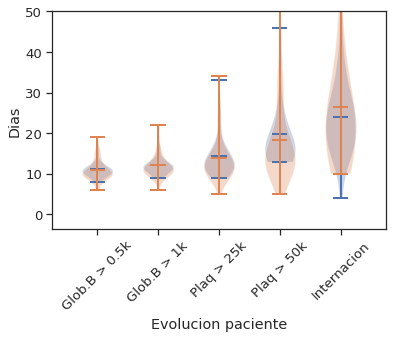

In [75]:
fig_viol, ax = plt.subplots()


Nevol = df2_NewMeth[cols]
Oevol = df2_OldMeth[cols]

# -- doesn't work with nan vals
Oevol.dropna(inplace=True)
Nevol.dropna(inplace=True)

# -- requiers np style
Nevol= Nevol.to_numpy()
Oevol= Oevol.to_numpy()

# -- Draw both
ax.violinplot(Nevol,showmeans=True)
ax.violinplot(Oevol,showmeans=True)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Evolucion paciente')
    
    ax.set_ylabel('Dias')
    ax.set_ylim(top=50)
    
plt.xticks(rotation=45)

labels=['Glob.B > 0.5k','Glob.B > 1k','Plaq > 25k','Plaq > 50k', 'Internacion']
set_axis_style(ax,labels)

# ax.set_xlabel(cols)



# Ahorro - Analisis 4

In [76]:
from datetime import date

# --Get from Date col the year of the procedure
Oyears = df_OldMeth['Fecha'].dt.year
Nyears = df_NewMeth['Fecha'].dt.year

# --Count how many procedures were made that year
Odist_byDate = Oyears.value_counts()
Ndist_byDate = Nyears.value_counts()

# --Add all to same DF
df_tot = pd.concat([Odist_byDate,Ndist_byDate])
df_tot = pd.concat([Odist_byDate,Ndist_byDate]).groupby(by=df_tot.index).sum()

*Parametros*

In [77]:
# -- Get mean and std

n = np.round(df_tot.mean())    # mean annual processes
n_err = np.round(df_tot.std()/np.sqrt(n),0)

print(f'Metodo viejo n = {n}({n_err})')


Metodo viejo n = 18.0(3.0)


In [78]:
def prop_err_sav(mean_new,mean_old,n,u,err_new,err_old,err_n,err_u):
    t1=mean_old*n*u*err_new
    t2=mean_new*u*n*err_old
    t3=(mean_new - mean_old)*n*err_u
    t4=(mean_new - mean_old)*u*err_n
    return np.sqrt(t1**2+t2**2+t3**2+t4**2)
    

### Data
dolar hoy 1 \\u$ = 95 \\$
aferesis set por unidad \\$ 23716 -> 249 u\\$
ACD (600ml) \\$1598 -> 17 u\\$
salario tecnico \\$35000 -> 368 u\\$

In [79]:
# --supongamos en u$
# u:: costos x proceso
u = 249 + 17 + 368
# --asumamos una fluctuacion de 10 dolares
u_err = 10

quality_gain = abs(mean_new - mean_old)


In [80]:
def ahorro(mean_new,mean_old,u,n):
    savings = abs(mean_new - mean_old) * u * n
    return savings
# err_savings =

err_saving = prop_err_sav(mean_new,mean_old,n,u,mean_new_err,mean_old_err,n_err,u_err)

err_saving=np.round(err_saving,0)

saving = np.round(ahorro(mean_new,mean_old,u,n),2)
print(f'ahorro = {saving}({err_saving})')




ahorro = 12324.96(4116.0)
